# [Machine Learning] K-Means Clustering


### Student ID : 20144367, Name : Lee, Donghyun


## 1. Problem

[Apply K-means algorithm to both image value and its spatial domain]

For a given input image (either gray or color), apply a K-means algorithm that is designed to take into consideration of both the image intensity and its spatial domain with varying parameters: the number of clusters and the trade-off between the intensity energy and the spatial energy.

The objective function is given by:

$$\sum_k \sum_{x \in I(k) } [ \| f(x) - m_k \|^2 + a * \| x - c_k \|^2 ]$$

where I(k) denotes the index set of x that belongs to cluster k, m_k denotes the centroid of image intensity for cluster k, c_k denotes the centroid of spatial location for cluster k, and a determines the importance between the image intensity and the spatial relation.

- Visualize the clustering results with varying k and a using the centroid color m_k for each cluster k. 

- Visualize the energy curve for both the intensity energy and the spatial energy.

## 2. Definition

### 2.1. K-Means Clustering

> k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

> Given a set of observations ${(x_1,x_2, \dots, x_n)}$, where each observation is a $d$-dmensional real vcector, k-means clustering aim to partition the $n$ obseravations into $k( \leq n)$ sets $C={\{C_1, C_2,\dots,C_k\}}$ so as to minimize the within-cluster sum of squares $(WCSS)$. Formally, the oct is to find : 
$$arg\;min \sum_{i=1}^k \sum_{x \in C_i} {\Vert x - \mu_i \Vert}^2 $$
where $\mu_i$ is the mean of points in $C$.

### < Codes \>

#### Libraries

In [156]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random
import math
import copy
from PIL import Image

#### Function L2Distance : Calculate L2 distance between two list

In [157]:
def L2Distance(listX, listY):

    x = np.array(listX)
    y = np.array(listY)

    sqrSumList = (x - y) ** 2    
    sqrSum = np.sum(sqrSumList)  
    result = np.sqrt(sqrSum)     
    
    return(result)

#### Function LoadImage : Read Image and save info in proper data structures

In [158]:
def LoadImage(imageFileName) :

    rawImage = Image.open(imageFileName)
    
    (cols, rows) = rawImage.size 
    imageTypeConversion = rawImage.convert("RGB")
    pixelMap_RGB = list(imageTypeConversion.getdata())

    x_coord = np.zeros(rows * cols, dtype = float)
    y_coord = np.zeros(rows * cols, dtype = float)
    
    # initialize x_coord and y_coord for input image(rows * cols)
    for i in range(0,rows) : 
        for j in range(0, cols) :
            x_coord[i * cols + j] = i
            y_coord[i * cols + j] = j
    
#    print("Image loading has been completed.")
    return (pixelMap_RGB, x_coord, y_coord, rows, cols)

#### Function InitialClusterSetup : Randomly group the pixels in K groups

In [159]:
def InitialClusterSetup(rows, cols, k) :
    
    clusterLabels = np.zeros(rows * cols, dtype = int)

    for i in range(rows * cols) :
        clusterLabels[i] = np.random.randint(0,k)
    
#    print("Cluster Initialization has been completed.")
    return clusterLabels

#### Function Normalization  : Normalize the input list and return the list with mean and standard deviation

In [160]:
def Normalize(inputList) :
    
    outputList = copy.deepcopy(inputList)
    np.asarray(outputList, dtype = float)
    mean = np.mean(outputList)
    stddev = np.std(outputList)
    
    for i in range(len(outputList)) :
        outputList[i] = (outputList[i] - mean) / stddev

    return outputList, mean, stddev

#### Function Denormalization : Denormalize the input list and return denormalized list

In [162]:
def Denormalize(inputList, mean, stddev) :

    outputList = copy.deepcopy(inputList)
    np.asarray(outputList)
    
    for i in range (len(outputList)) :
        for j in range(3) :
            outputList[i][j] = int(stddev * inputList[i][j] + mean)
    
    return outputList

#### Function SpaticalCentroidCalculation : Determine spatial centroid vector(x,y) with average vectors in cluster k (L2-Norm used.)

In [163]:
def SpatialCentroidCalculation(clusterLabels, x_coord, y_coord, rows, cols, k) :
    
    centroidCoord = np.zeros((k,2), dtype = float)
    centroidCount = np.zeros(k, dtype = float)
    
    for i in range(rows * cols) :
        centroidCoord[clusterLabels[i]] += (x_coord[i], y_coord[i])
        centroidCount[clusterLabels[i]] += 1
    
    for i in range(k) :
        if centroidCount[i] == 0 :
            centroidCoord[i] = (0.0,0.0)
            continue
        centroidCoord[i] = (centroidCoord[i][0] / centroidCount[i], centroidCoord[i][1] / centroidCount[i])

#    print("Spatial Centroid Calculation has been completed with average of new clusters' centroid vector.")
    
    return centroidCoord

#### Function ColorCentroidCalculation : Determine color centroid vector(R,G,B) with average vectors in cluster k (L2-Norm used.)

In [164]:
def ColorCentroidCalculation(clusterLabels, pixelMap_RGB, rows, cols, k) :

    centroidCoord = np.zeros((k, 3), dtype = float)
    centroidCount = np.zeros(k, dtype = float)

    for i in range(0, rows * cols) :
        centroidCoord[clusterLabels[i]] += pixelMap_RGB[i]
        centroidCount[clusterLabels[i]] += 1
    
    for i in range(0, k) :
        if centroidCount[i] == 0 :
            centroidCoord[i] = (0.0,0.0,0.0)
            continue
        centroidCoord[i] /= centroidCount[i]

#    print("Cluster Count : ", centroidCount)
#    print("Color Centroid Calculation has been completed with average of new clusters' centroid vector.")
    return centroidCoord

#### Function ClusterRebuild : Rebuild cluster using L2 distances between pixels and centroid vectors ((R,G,B), (x,y))

In [165]:
def ClusterRebuild(pixelMap_RGB, colorCV, x_coord, y_coord, spatialCV, rows, cols, k, a) :

    list_distance = np.zeros(k, dtype = float)
    list_energy = np.zeros(k, dtype = float)
    newClusterLabels = np.zeros(rows * cols, dtype = int)
    
    for i in range(rows * cols) :
        for j in range(k) :
            list_distance[j] = L2Distance(pixelMap_RGB[i], colorCV[j]) + a * L2Distance((x_coord[i],y_coord[i]),spatialCV[j])
        new_label = np.argmin(list_distance)
        list_energy[new_label] += list_distance[new_label]
        newClusterLabels[i] = new_label

#    print("Cluster reconstruction completed with L2 distance. New label has been chosen.")
    return newClusterLabels, list_energy

#### Function CalculateEnergy : Calculate Energy

In [166]:
def CalculateEnergy(list_distance, rows, cols) :
    energy = np.sum(list_distance) / (rows * cols)
#    print("Energy calculation completed.")
    return (energy)

#### Function k_coloring : Return the List[(R,G,B)] colored with centorid vector of each cluster

In [167]:
def K_Coloring(clusterLabels, colorCV, rows, cols, k) :
    data_size = rows * cols
    k_ColoredImage = np.zeros((int(data_size), 3), dtype = float)
    clusterSize = np.zeros(k, dtype = int)

    for i in range(0, data_size) :
        k_ColoredImage[i] = colorCV[clusterLabels[i]]
        clusterSize[clusterLabels[i]] += 1
#    print("Image has been colored with", k,"colors")
    return k_ColoredImage

#### Function PlotEnergyCurve : Plot energy curve

In [168]:
def PlotEnergyCurve(list_energy, k,a) :
    title = 'Energy per Optimization Iteration when K = ' + str(k) + 'and a = ' + str(a)
    plt.xlabel('iteration')
    plt.ylabel('energy')
    plt.title(title)
    plt.plot(list_energy)
    plt.show()

#### Function k_mean_clustering : Process K-mean clustering and display k-colored image

In [169]:
def K_mean_clustering(imageFileName, k, a, maximum_round, threshold) :
    
    list_distance = np.zeros(k, dtype = float)
    list_energy = []
    prevEnergy = 0
    currentEnergy = 0

    (pixelMap_RGB, x_coord, y_coord, rows, cols) = LoadImage(imageFileName)

    data_size = rows * cols
    NpixelMap_RGB,pMean, pStd = Normalize(pixelMap_RGB)
    Nx_coord, xMean, xStd = Normalize(x_coord)
    Ny_coord, yMean, yStd = Normalize(y_coord)
        
    clusterLabels = InitialClusterSetup(rows, cols, k)

    for i in range(maximum_round) :
#        print("[ Round",i+1, "]")
        spatialCV = SpatialCentroidCalculation(clusterLabels, Nx_coord, Ny_coord, rows, cols, k)
        colorCV = ColorCentroidCalculation(clusterLabels, NpixelMap_RGB, rows, cols, k)
        
#        print("Color : ")
#        print(colorCV)
#        print("Spatial : ")
#        print(spatialCV)
        clusterLabels, list_distance = ClusterRebuild(NpixelMap_RGB, colorCV, Nx_coord, Ny_coord, spatialCV, rows, cols, k, a)
        currentEnergy = CalculateEnergy(list_distance, rows, cols)
        list_energy.append(currentEnergy)
#        print(currentEnergy)

        if np.absolute(currentEnergy - prevEnergy) / currentEnergy < threshold :
            break

#        print("Energy Change Rate : ", np.absolute(currentEnergy - prevEnergy) / currentEnergy)
        prevEnergy = currentEnergy
        currentEnergy = 0

    
    denorm = Denormalize(colorCV, pMean, pStd)
    
    k_coloredImage = K_Coloring(clusterLabels, denorm, rows, cols, k)
    
#    print(k_coloredImage)
    
    result = np.zeros((data_size,3),dtype = int)
    newImage = []
    
    for i in range(0, data_size) :
        for j in range(0, 3) :
            result[i][j] = int(k_coloredImage[i][j])

    for i in range(0, data_size) :
        newImage.append(tuple(result[i]))
    
#    print("Data size : ", rows * cols, "Real : ", len(newImage))
#    print("Rows : ", rows, "cols : ", cols)
    resultImage = Image.new("RGB", (cols, rows))    

    resultImage.putdata(newImage)
        
    display(resultImage)
    
#    print("# of energy trial : ", len(list_energy))
    PlotEnergyCurve(list_energy, k,a)

### [ Results ]

#### 1. K = 5, a = [0.1, 0.7, 1.6, 2.0]

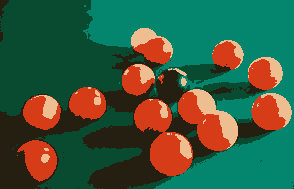

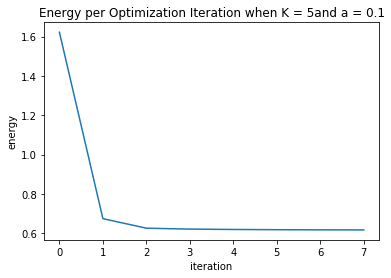

In [170]:
imageFileName = "billiard.jpg"
k = 5
a = 0.1
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

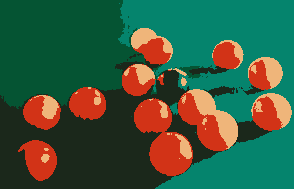

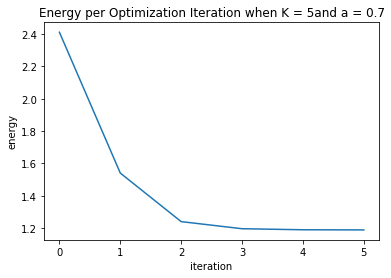

In [171]:
imageFileName = "billiard.jpg"
k = 5
a = 0.7
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

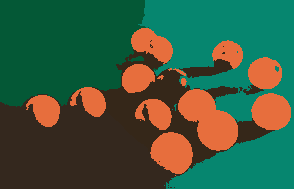

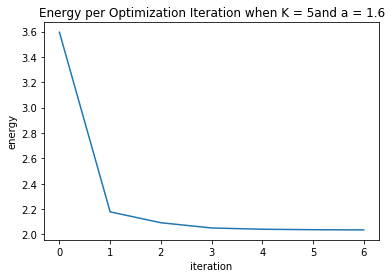

In [172]:
imageFileName = "billiard.jpg"
k = 5
a = 1.6
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

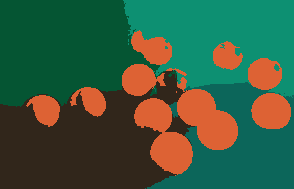

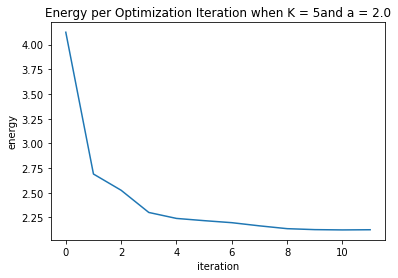

In [173]:
imageFileName = "billiard.jpg"
k = 5
a = 2.0
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

#### 2. K = 10, a = [0.1, 0.7, 1.6, 2.0]

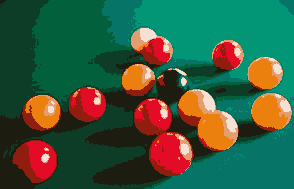

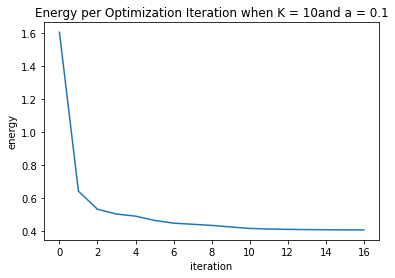

In [174]:
imageFileName = "billiard.jpg"
k = 10
a = 0.1
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

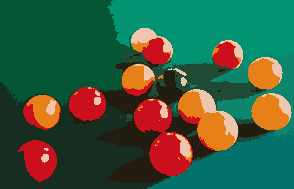

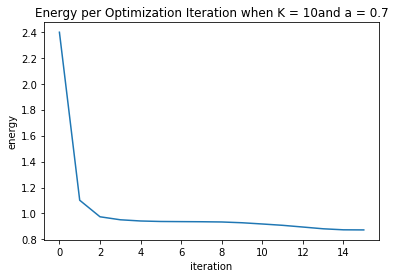

In [175]:
imageFileName = "billiard.jpg"
k = 10
a = 0.7
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

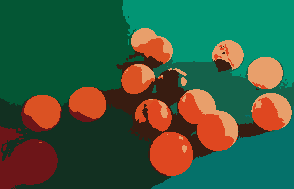

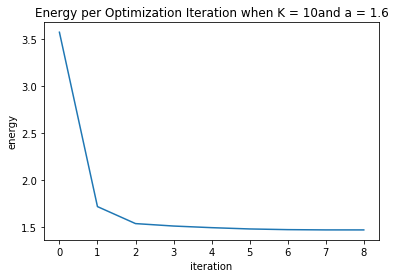

In [176]:
imageFileName = "billiard.jpg"
k = 10
a = 1.6
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

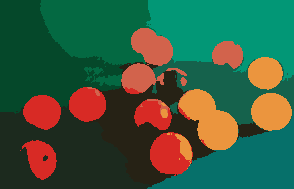

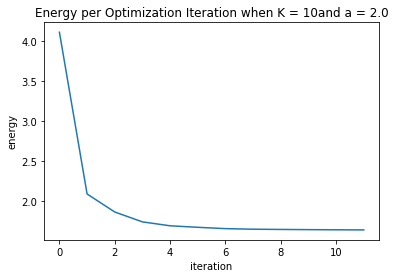

In [177]:
imageFileName = "billiard.jpg"
k = 10
a = 2.0
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)

#### Special case : a = 20

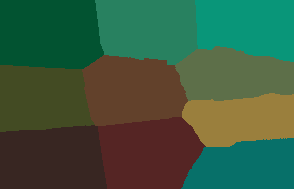

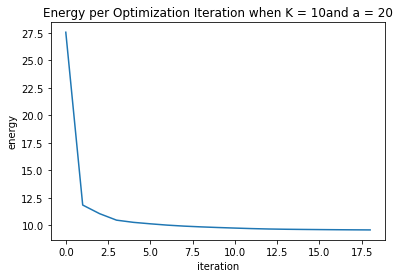

In [182]:
imageFileName = "billiard.jpg"
k = 10
a = 20
maximum_round = 100
threshold = 0.001

K_mean_clustering(imageFileName, k, a, maximum_round, threshold)